In [7]:
from utils import *
from preprocessing import *
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision.datasets import ImageFolder
from skimage import feature
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image



In [31]:
transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )



num_classes = 10
dataset = ImageFolder(root="./split_dataset/train", transform=transform)

# Create a subset of first 100 images
indices = list(range(500))
subset = Subset(dataset, indices)

dataloader = DataLoader(subset, batch_size=64, shuffle=True)


In [32]:
model = torchvision.models.resnet18(pretrained=True)
# model = torchvision.models.resnet50(pretrained=True) # RESNET50
# model = torchvision.models.vgg16(pretrained=True) #VGG16
# model =  torchvision.models.inception_v3(pretrained=True) # INCEPTION V3
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
numEpochs = 3

def trainModel():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(numEpochs):
        for images, labels in dataloader:
            images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{numEpochs}], Loss: {loss.item():.4f}")

In [34]:
trainModel()

Epoch [1/3], Loss: 0.8897
Epoch [2/3], Loss: 0.7771
Epoch [3/3], Loss: 0.3903


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  2 3 0 0
GroundTruth:  0 0 0 0


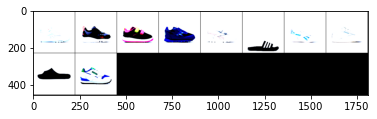

In [35]:
testset = ImageFolder(root="./split_dataset/train", transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False)

dataiter = iter(testloader)
images, labels = dataiter.__next__()


classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))
# print images
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 21 %


In [86]:
import os
import numpy as np
from typing import Tuple

# Assuming 'load_imagepaths_with_labels' loads image paths and corresponding labels
# and 'open_image' opens the image from a given path

def split_images(src_folder: str, dst_folder: str, p: float = 0.2) -> Tuple[int, int]:
    img_paths = load_imagepaths_with_labels(src_folder)  # This should return a list of tuples
    val_count = 0
    train_count = 0
    for (path, label) in img_paths:
        r = np.random.uniform()
        img = open_image(path)
        # Choose the directory based on the random number
        subdir = "val" if r < p else "train"
        # Use the label as the directory name
        label_dir = os.path.join(dst_folder, subdir, str(label))
        os.makedirs(label_dir, exist_ok=True)  # Create the directory if it doesn't exist
        # Extract the filename from the path
        filename = os.path.basename(path)
        # Save the image in the directory named after the label
        img.save(os.path.join(label_dir, filename))
        # Increment the appropriate counter
        if subdir == "val":
            val_count += 1
        else:
            train_count += 1
    return val_count, train_count

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


class CustomModel(nn.Module):
    def __init__(
        self,
        root_path,
        num_classes=2,
        batch_size=32,
        num_epochs=10,
        learning_rate=0.001,
    ):
        super(CustomModel, self).__init__()
        self.root_path = root_path
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate

        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

        self.dataset = ImageFolder(root=self.root_path, transform=self.transform)
        self.dataloader = DataLoader(
            self.dataset, batch_size=self.batch_size, shuffle=True
        )

        self.model = torchvision.models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, self.num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def trainModel(self):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        for epoch in range(self.num_epochs):
            for images, labels in self.dataloader:
                images.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item():.4f}")

    def saveModel(self, save_path):
        torch.save(self.model.state_dict(), save_path)


if __name__ == "__main__":
    model = CustomModel(
        root_path="./split_dataset/train", num_classes=10, batch_size=512, num_epochs=1
    )
    model.trainModel()
    model.saveModel("model.pth")

/Users/tawsifkamal/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tawsifkamal/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.__version__